# Machine Learning
### Kernel density estimation for two dimensional case (2D KDE)
**2D Kernel density estimation** (**KDE**) is a non-parametric method for estimating the **probability density function** (**pdf**) of a **bivariate** (2D) dataset. 
- It places a kernel function (usually symmetric) at each data point,
- and sums these kernels to create a smooth density surface. 

Given $n$ bivariate samples ${(x_1,y_1),(x_2,y_2),...,(x_n,y_n)}$ from an unknown joint density f(x,y), the 2D KDE estimator is:
<br>$\large \hat{f}(x,y)=\frac{1}{n\cdot h_x \cdot h_y}\sum_{i=1}^n K(\frac{x-x_i}{h_x},\frac{y-y_i}{h_y})$ &emsp;(1)
<br> Where:
- $K$: kernel function (non-negative, symmetric, finite second moment, integrates to 1)
- $h_x>0$ and $h_y>0$: bandwidths for $x$ and $y$ dimensions (smoothing parameters)
- $n$: number of data points

Some ways to produce 2D kernels from 1D kernels include:
- Product rule: $K_{2D}(u,v)=K_{1D}(u)\cdot K_{1D}(v)$
- Radial rule: $K_{2D}(u,v)=K_{1D}^r(u^2+v^2)$ where $K_{1D}^r(r)$ is a modified radial version of the 1D kernel.
    - For Gaussian, we get $K^r(r)=\frac{1}{\pi}e^-{r^2/2}$.
    - For Epanechnikov, we get $K^r(r)=\frac{2}{\pi}(1-r^2)$ for $r\le1$
    - For uniform, we get $K^r(r)=\frac{1}{\pi}$ for $r\le1$
    - Reminder: the radial distance is: $r=\sqrt{u^2+v^2}$


<hr>

Some rules of **bandwidth selecion** for $d$-dimensional data points:
- **Silverman's** rule for component $j$ with standard deviation $\sigma_j$:
    - $h_j=C_{kernel}(d)\cdot \sigma\cdot n^{-\frac{1}{d+4}}$, where $C_{kernel}(d)$ is both dependent on the type of kernel and on the dimension $d$ of data points.
        - For Gaussian kernel $K(u)=\frac{1}{\sqrt{2\pi}}e^{-u^2/2}$: $C_{Gaussian}(d)=(\frac{4}{d+2})^\frac{1}{d+4}$
        - For Epanechnikov kernel $K(u)=\frac{3}{4}(1-u^2)$ for $|u|\le1$: $C_{Epan}(1)\approx 1.7188$, $C_{Epan}(2)\approx 1.3634$, $C_{Epan}(3)\approx 1.2160$, etc.
        - For uniform kernel $K(u)=\frac{1}{2}$ for $|u|\le1$: $C_{uniform}(1)\approx 1.3510$, $C_{uniform}(2)\approx 1.0845$, $C_{uniform}(3)\approx 0.9792$, etc.
    - 
- **Scott's** rule for component $j$ with standard deviation $\sigma_j$:
    - $h_j=\sigma\cdot n^{-\frac{1}{d+4}}$

**Hint:** To compute PDF for a new 2D point $(x,y)$, we first choose the kernel $K$, and the bandwidths $h_X$ and $h_y$. Then, we estimate the PDF at point $(x,y)$ ($pdf(x,y)$) by using formula (1) with $(x,y)$ and given $n$ data points $(x_i,y_i)$. 
<hr>

In the following, 
- We first implement Kernel Density Estimation (KDE) from scratch by defining the `class` **KDE2D** in python. 
- Then, we test the KDE 2D predict functions with a simple dataset. 
- Next, our KDE 2D os tested against syntethic data composed of samples of two normal distributions. 
- As an extra code, we give a minimal code for KDE 2D.
- Finally, as a bonus, we use `KernelDensity` of **Scikit-learn** to implmenet KDE 2D.

<hr>

https://github.com/ostad-ai/Machine-Learning
<br> Explanation: https://www.pinterest.com/HamedShahHosseini/Machine-Learning/

In [1]:
# Import required modules
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
class KDE2D:
    """2D Kernel Density Estimation with fit/predict interface"""
    
    def __init__(self, kernel='gaussian', bandwidth=None):
        """
        Initialize 2D KDE estimator        
        Parameters:
        -----------
        kernel : str
            'gaussian' (default), 'epanechnikov', or 'uniform'
        bandwidth : float, tuple, or None
            If float: same bandwidth for both dimensions
            If tuple: (hx, hy) for x and y dimensions
            If None: uses Silverman's rule
        """
        self.kernel = kernel
        self.bandwidth = bandwidth
        self.x_data = None
        self.y_data = None
        self.hx = None
        self.hy = None
        
    def fit(self, x, y):
        """
        Fit KDE to 2D data
        
        Parameters:
        -----------
        x : array-like, shape (n,)
            X-coordinates of data points
        y : array-like, shape (n,)
            Y-coordinates of data points
        """
        self.x_data = np.asarray(x)
        self.y_data = np.asarray(y)
        self.n = len(self.x_data)
        
        # Check data consistency
        if len(self.y_data) != self.n:
            raise ValueError("x and y must have same length")
        
        # Set bandwidth
        if self.bandwidth is None:
            self.hx, self.hy = self._optimal_bandwidth()
        elif np.isscalar(self.bandwidth):
            self.hx = self.bandwidth
            self.hy = self.bandwidth
        else:
            self.hx, self.hy = self.bandwidth
            
        return self
    
    def _optimal_bandwidth(self):
        """Optimal bandwidth for 2D kernels using radial rule"""
        sigma_x = np.std(self.x_data)
        sigma_y = np.std(self.y_data)
        n = self.n
        
        # Use 2D constants and n^{-1/6} exponent
        if self.kernel == 'gaussian':
            constant = 1.00  # (4/(2+2))^(1/6) = 1
        elif self.kernel == 'epanechnikov':
            constant = 1.36  # Radial constant for 2D
        elif self.kernel == 'uniform':
            constant = 1.08  # Radial constant for 2D
        else:
            constant = 1.00
        
        # Use n^{-1/6} for 2D 
        hx = constant * sigma_x * n**(-1/6)
        hy = constant * sigma_y * n**(-1/6)
        
        return hx, hy
    
    def _kernel_function(self, u, v):
        """Evaluate 2D kernel function using radial rule"""
        if self.kernel == 'gaussian':
            return np.exp(-0.5 * (u**2 + v**2)) / (2 * np.pi)
        elif self.kernel == 'epanechnikov':
            r2 = u**2 + v**2
            return (2 / np.pi) * (1 - r2) * (r2 <= 1)
        elif self.kernel == 'uniform':
            return (1 / np.pi) * ((u**2 + v**2) <= 1)
        else:
            raise ValueError(f"Unknown kernel: {self.kernel}")
    
    def predict(self, x_points, y_points):
        """
        Predict density at given points
        
        Parameters:
        -----------
        x_points, y_points : arrays
            Points where to evaluate density
            
        Returns:
        --------
        densities : array
            Density estimates at points
        """
        x_pts = np.asarray(x_points).reshape(-1)
        y_pts = np.asarray(y_points).reshape(-1)
        
        if len(x_pts) != len(y_pts):
            raise ValueError("x_points and y_points must have same length")
        
        densities = np.zeros_like(x_pts, dtype=float)
        
        # Vectorized computation
        for i in range(len(x_pts)):
            u = (x_pts[i] - self.x_data) / self.hx
            v = (y_pts[i] - self.y_data) / self.hy
            densities[i] = np.sum(self._kernel_function(u, v)) / (self.n * self.hx * self.hy)
        
        # Reshape to match input shape
        return densities.reshape(np.asarray(x_points).shape)
    
    def predict_fast(self, x_points, y_points):
        """Faster vectorized prediction"""
        x_pts = np.asarray(x_points).reshape(-1, 1)
        y_pts = np.asarray(y_points).reshape(-1, 1)
        
        # Compute all pairwise distances
        u = (x_pts - self.x_data) / self.hx  # shape: (m, n)
        v = (y_pts - self.y_data) / self.hy  # shape: (m, n)
        
        # Apply kernel
        # Use the same kernel function
        kernel_vals = self._kernel_function(u, v)
        
        # Average over data points and normalize
        densities = np.mean(kernel_vals / (self.hx * self.hy), axis=1)
        
        # Reshape to match input
        return densities.reshape(np.asarray(x_points).shape)
    
    def grid_predict(self, x_range=None, y_range=None, grid_size=100):
        """
        Predict density on a regular grid
        
        Parameters:
        -----------
        x_range : tuple or None
            (x_min, x_max) for grid
        y_range : tuple or None
            (y_min, y_max) for grid
        grid_size : int
            Grid size (grid_size x grid_size)
            
        Returns:
        --------
        X : array, shape (grid_size, grid_size)
            X-coordinates of grid
        Y : array, shape (grid_size, grid_size)
            Y-coordinates of grid  
        Z : array, shape (grid_size, grid_size)
            Density at grid points
        """
        if x_range is None:
            x_min = self.x_data.min() - 3 * self.hx
            x_max = self.x_data.max() + 3 * self.hx
        else:
            x_min, x_max = x_range
            
        if y_range is None:
            y_min = self.y_data.min() - 3 * self.hy
            y_max = self.y_data.max() + 3 * self.hy
        else:
            y_min, y_max = y_range
        
        # Create grid
        xi = np.linspace(x_min, x_max, grid_size)
        yi = np.linspace(y_min, y_max, grid_size)
        X, Y = np.meshgrid(xi, yi)
        
        # Predict on grid using fast method
        Z = self.predict_fast(X, Y)
        
        return X, Y, Z

In [11]:
# Test that both methods give same result
x = np.random.randn(50)
y = np.random.randn(50)

kde = KDE2D(kernel='epanechnikov')
kde.fit(x, y)

test_x = [0, 1, 2]
test_y = [0, 1, 2]

slow_result = kde.predict(test_x, test_y)
fast_result = kde.predict_fast(test_x, test_y)

print("Slow predict:", slow_result)
print("Fast predict:", fast_result)
print("Max difference:", np.max(np.abs(slow_result - fast_result)))

Slow predict: [0.14831245 0.12392972 0.00623821]
Fast predict: [0.14831245 0.12392972 0.00623821]
Max difference: 2.7755575615628914e-17


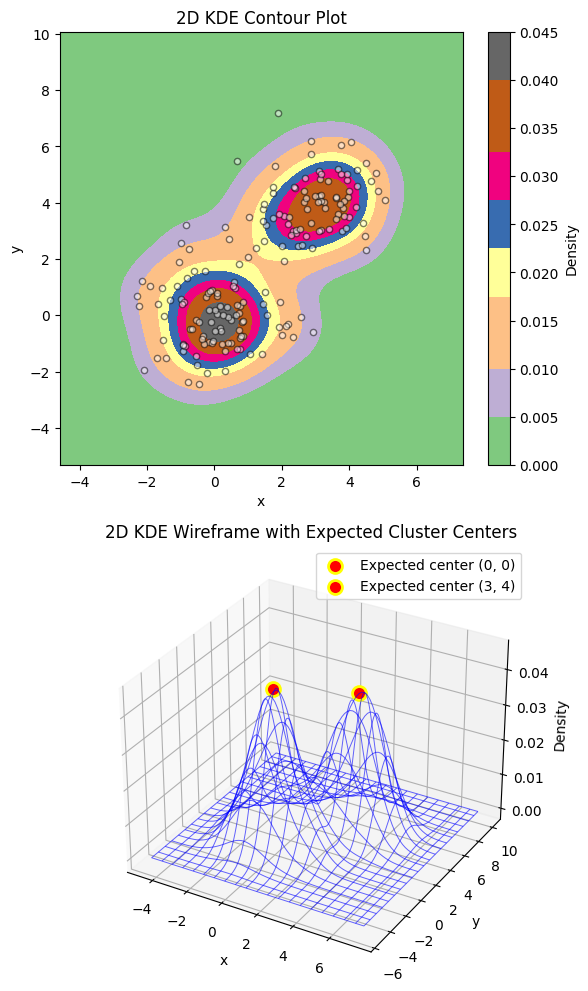

In [12]:
# Generate sample data
x = np.concatenate([
    np.random.normal(0, 1, 100),
    np.random.normal(3, 1, 80)])
y = np.concatenate([
    np.random.normal(0, 1, 100),
    np.random.normal(4, 1, 80)])
# Create and fit KDE
kde = KDE2D(kernel='gaussian')
kde.fit(x, y)
# Use grid_predict
X, Y, Z = kde.grid_predict(grid_size=80)

plt.figure(figsize=(6, 10))

# 1. Contour plot
plt.subplot(2, 1, 1)
plt.contourf(X, Y, Z, levels=20, cmap=plt.cm.Accent)
plt.colorbar(label='Density')
plt.scatter(x, y, alpha=0.5, s=20, c='white', edgecolors='black')
plt.title('2D KDE Contour Plot')
plt.xlabel('x'); plt.ylabel('y')


# 2. Create wireframe plot
ax = plt.subplot(2, 1, 2, projection='3d')

# The expected cluster centers
expected_centers = [(0, 0), (3, 4)]

# Wireframe
ax.plot_wireframe(X, Y, Z, rstride=4, cstride=4, 
                 alpha=0.6, linewidth=0.7, color='blue')

# Mark the expected cluster centers with red dots
for center_x, center_y in expected_centers:
    # Get density at expected center
    density = kde.predict_fast([center_x], [center_y])[0]
    ax.scatter([center_x], [center_y], [density], 
              color='red', s=100, marker='o',
              edgecolors='yellow', linewidth=2,
              label=f'Expected center ({center_x}, {center_y})')

ax.set_xlabel('x'); ax.set_ylabel('y')
ax.set_zlabel('Density')
ax.set_title('2D KDE Wireframe with Expected Cluster Centers')
ax.legend(); plt.tight_layout()
plt.show()

<hr style="height:3px; background:lightgreen">

# Extra
#### A minical code for KDE 2D

In [13]:
# ============================================
# Minimal 2D KDE (15 lines)
# ============================================

class SimpleKDE2D:
    """Minimal 2D KDE with Gaussian kernel"""
    def __init__(self, h=None):
        self.h = h
        
    def fit(self, x, y):
        self.x = np.array(x)
        self.y = np.array(y)
        self.n = len(x)
        if self.h is None:
            hx = np.std(x) * self.n**(-1/6)
            hy = np.std(y) * self.n**(-1/6)
            self.h = (hx, hy)
        return self
    
    def predict(self, x_points,y_points):
        x_pts, y_pts = np.array(x_points), np.array(y_points)
        x_flat, y_flat = x_pts.reshape(-1, 1), y_pts.reshape(-1, 1)
        hx, hy = self.h
        
        u = (x_flat - self.x) / hx
        v = (y_flat - self.y) / hy
        return np.mean(np.exp(-0.5*(u**2+v**2))/(hx*hy*2*np.pi),\
                       axis=1).reshape(x_pts.shape)

In [14]:
# Test the KDE2D and simpleKDE2D
# data from a 2D normal distribution
x = np.random.randn(50)
y = np.random.randn(50)

# Implements only Gaussian kernel
kde_simple = SimpleKDE2D()
kde_simple.fit(x, y)

# Implements three types of kernel
kde_original=KDE2D()
kde_original.fit(x,y)

test_x = [0, 1, 2]; test_y = [0, 1, 2]

pdf_test_simple = kde_simple.predict(test_x, test_y)
print("predicted pdf (minimal KDE 2D): ", pdf_test_simple)
#------------
pdf_test_original = kde_original.predict(test_x, test_y)
print("predicted pdf (original KDE 2D):", pdf_test_original)

predicted pdf (minimal KDE 2D):  [0.12444488 0.0467032  0.00889884]
predicted pdf (original KDE 2D): [0.12444488 0.0467032  0.00889884]


<hr style="height:3px; background-color:lightblue">

# Bonus
#### We use `KernelDensity` in Scikit-Learn for KDE 2D

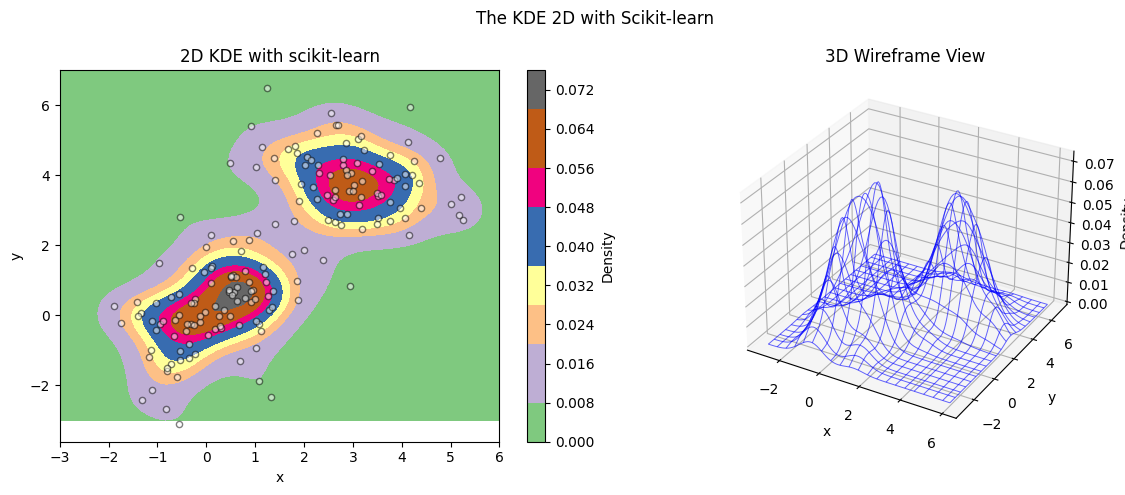

Data shape: (180, 2)
Density range: [0.0000, 0.0733]
Bandwidth used: 0.5


In [15]:
# Bonus
from sklearn.neighbors import KernelDensity
# Generate sample data
n1, n2 = 100, 80
data = np.vstack([
    np.random.multivariate_normal([0, 0], [[1, 0.3], [0.3, 1]], n1),
    np.random.multivariate_normal([3, 4], [[1, -0.2], [-0.2, 0.8]], n2)
])

# Create and fit KDE with scikit-learn
kde_SL = KernelDensity(bandwidth=0.5, kernel='gaussian')
kde_SL.fit(data)

# Create grid for evaluation
x = np.linspace(-3, 6, 80)
y = np.linspace(-3, 7, 80)
X, Y = np.meshgrid(x, y)
xy_grid = np.vstack([X.ravel(), Y.ravel()]).T

# Compute log density, then convert to density
log_density = kde_SL.score_samples(xy_grid)
Z = np.exp(log_density).reshape(X.shape)

# Plot
fig = plt.figure(figsize=(12, 5))

# 2D contour
ax1 = plt.subplot(1, 2, 1)
contour = ax1.contourf(X, Y, Z, levels=20, cmap=plt.cm.Accent)
ax1.scatter(data[:, 0], data[:, 1], alpha=0.5, s=20, c='white', edgecolors='black')
plt.colorbar(contour, ax=ax1, label='Density')
ax1.set_title('2D KDE with scikit-learn')
ax1.set_xlabel('x')
ax1.set_ylabel('y')

# 3D wireframe
ax2 = plt.subplot(1, 2, 2, projection='3d')
ax2.plot_wireframe(X, Y, Z, rstride=4, cstride=4, alpha=0.6, linewidth=0.7, color='blue')
ax2.set_title('3D Wireframe View')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('Density')
plt.suptitle('The KDE 2D with Scikit-learn')
plt.tight_layout()
plt.show()

# Print some info
print(f"Data shape: {data.shape}")
print(f"Density range: [{Z.min():.4f}, {Z.max():.4f}]")
print(f"Bandwidth used: {kde_SL.bandwidth}")